# Miller age

In [1]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [3]:
ood_seed = 1
num_ood = 1

In [4]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

def adata_ood_creator(adata, seed, size):
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
    adata.obs["age_continuous"] = adata.obs["age"].astype(float)
    df = adata.obs.groupby(["cell_type", "age"]).size()
    df2 = adata.obs.groupby(["cell_type"]).size()
    availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 350]
    rng = np.random.default_rng(seed=seed)
    random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    choices = [availables[i] for i in random_choices]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Hub cells', '15.0'), 308)

Removed datapoint: 308


In [5]:
adata

AnnData object with n_obs × n_vars = 7097 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_continuous'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'

In [6]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"miller_age_ood-seed-{ood_seed}"
)

In [7]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/miller_age_ood-seed-1/model.pt already 
         downloaded                                                                                                


CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8907, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
warmup_epoch_range = [12, 48]
# _, n_epochs_kl_warmup = warmup_epoch_range
n_epochs_kl_warmup = 400

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "age",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 100,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 10, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=32, 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.1,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=1000,
    train_size=0.8,
    batch_size=512,
    check_val_every_n_epoch=10,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=True,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-3,
        weight_decay=1e-6,
        # optimizer="AdamW"
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    ),
    limit_train_batches=0.5, 
    limit_val_batches=0.5,
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key="concatenated_integration_covariates",
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(adata, **model_params)
vae.train(**train_params)

vae.save(
    dir_path,
    overwrite=True,
)

CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8907, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-d7527232-b423-53a6-b24b-0b680aeec10f,MIG-16007a59-529c-5576-835b-d41589ac37ab]
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-p

Epoch 1/1000:   0%|                                                                                                                            | 0/1000 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `age` for `training` set. Number of elements in each group: 557,2098,2399,624
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 2/1000:   0%|           | 1/1000 [00:01<31:32,  1.89s/it, v_num=1, total_loss_train=1.2e+3, kl_local_train=22.4, tardis_age_0_train=40.2, tardis_age_1_train=17.7]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `age` for `validation` set. Number of elements in each group: 150,518,606,145
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 523/1000:  52%|█████▏    | 522/1000 [04:00<03:39,  2.18it/s, v_num=1, total_loss_train=696, kl_local_train=27.8, tardis_age_0_train=17.3, tardis_age_1_train=5.92]

In [ ]:
batch_size_vae_metrics = 512
vae_metrics = {
    "reconstruction_error": vae.get_reconstruction_error(batch_size=batch_size_vae_metrics)['reconstruction_loss'],
    "elbo": vae.get_elbo(batch_size=batch_size_vae_metrics).item(),
    "r2_train": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_train_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_train_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_validation": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    "r2_validation_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    "r2_validation_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
}
for k, v in vae_metrics.items():
    print(k, v)

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "cell_type"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [ ]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [ ]:
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood), obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood, n_neighbors = 30)
sc.tl.umap(latent_ood)

In [ ]:
from scanpy.tools import Ingest as sc_Ingest
def label_transfer(
    reference_embeddings: ad.AnnData,
    query_embeddings: ad.AnnData,
    cluster_list: list[str],
    neighbors_count: int,
):
    # Compute a joint neighbor graph for reference and query embeddings
    joint_graph = sc_Ingest(reference_embeddings)
    joint_graph.fit(query_embeddings)
    joint_graph.neighbors(k=neighbors_count)

    # Calculate distances to top neighbors_count neighbors for each cell and store indices
    top_neighbor_distances, top_neighbor_indices = joint_graph._distances, joint_graph._indices

    # Transform distances with Gaussian kernel
    distance_stds = np.std(top_neighbor_distances, axis=1)
    distance_stds = (2.0 / distance_stds) ** 2
    distance_stds = distance_stds.reshape(-1, 1)
    transformed_distances = np.exp(-np.true_divide(top_neighbor_distances, distance_stds))

    # Normalize transformed distances so that they sum to 1
    normalized_weights = transformed_distances / np.sum(transformed_distances, axis=1, keepdims=True)

    # Initialize empty series to store predicted labels and uncertainties for each query cell
    cell_uncertainties = pd.Series(index=query_embeddings.obs_names, dtype="float64")
    predicted_labels = pd.Series(index=query_embeddings.obs_names, dtype="object")

    # Iterate through query cells
    for cluster in cluster_list:
        train_labels = reference_embeddings.obs[cluster].values
        for index in range(len(normalized_weights)):
            # Store cell types present among neighbors in reference
            unique_cell_types = np.unique(train_labels[top_neighbor_indices[index]])

            # Store best label and corresponding probability
            best_cell_type, best_probability = None, 0.0

            # Iterate through all cell types present among the cell's neighbors
            for label in unique_cell_types:
                prob = normalized_weights[index, train_labels[top_neighbor_indices[index]] == label].sum()
                if best_probability < prob:
                    best_probability = prob
                    best_cell_type = label
            else:
                final_label = best_cell_type

            # Store best label and corresponding uncertainty
            cell_uncertainties.iloc[index] = max(1 - best_probability, 0)
            predicted_labels.iloc[index] = final_label

        query_embeddings.obs[f"transf_{cluster}"] = predicted_labels
        query_embeddings.obs[f"transf_{cluster}_unc"] = cell_uncertainties

In [ ]:
label_transfer(latent, latent_ood, cluster_list=["age"], neighbors_count=30)

In [ ]:
latent_ood.obs

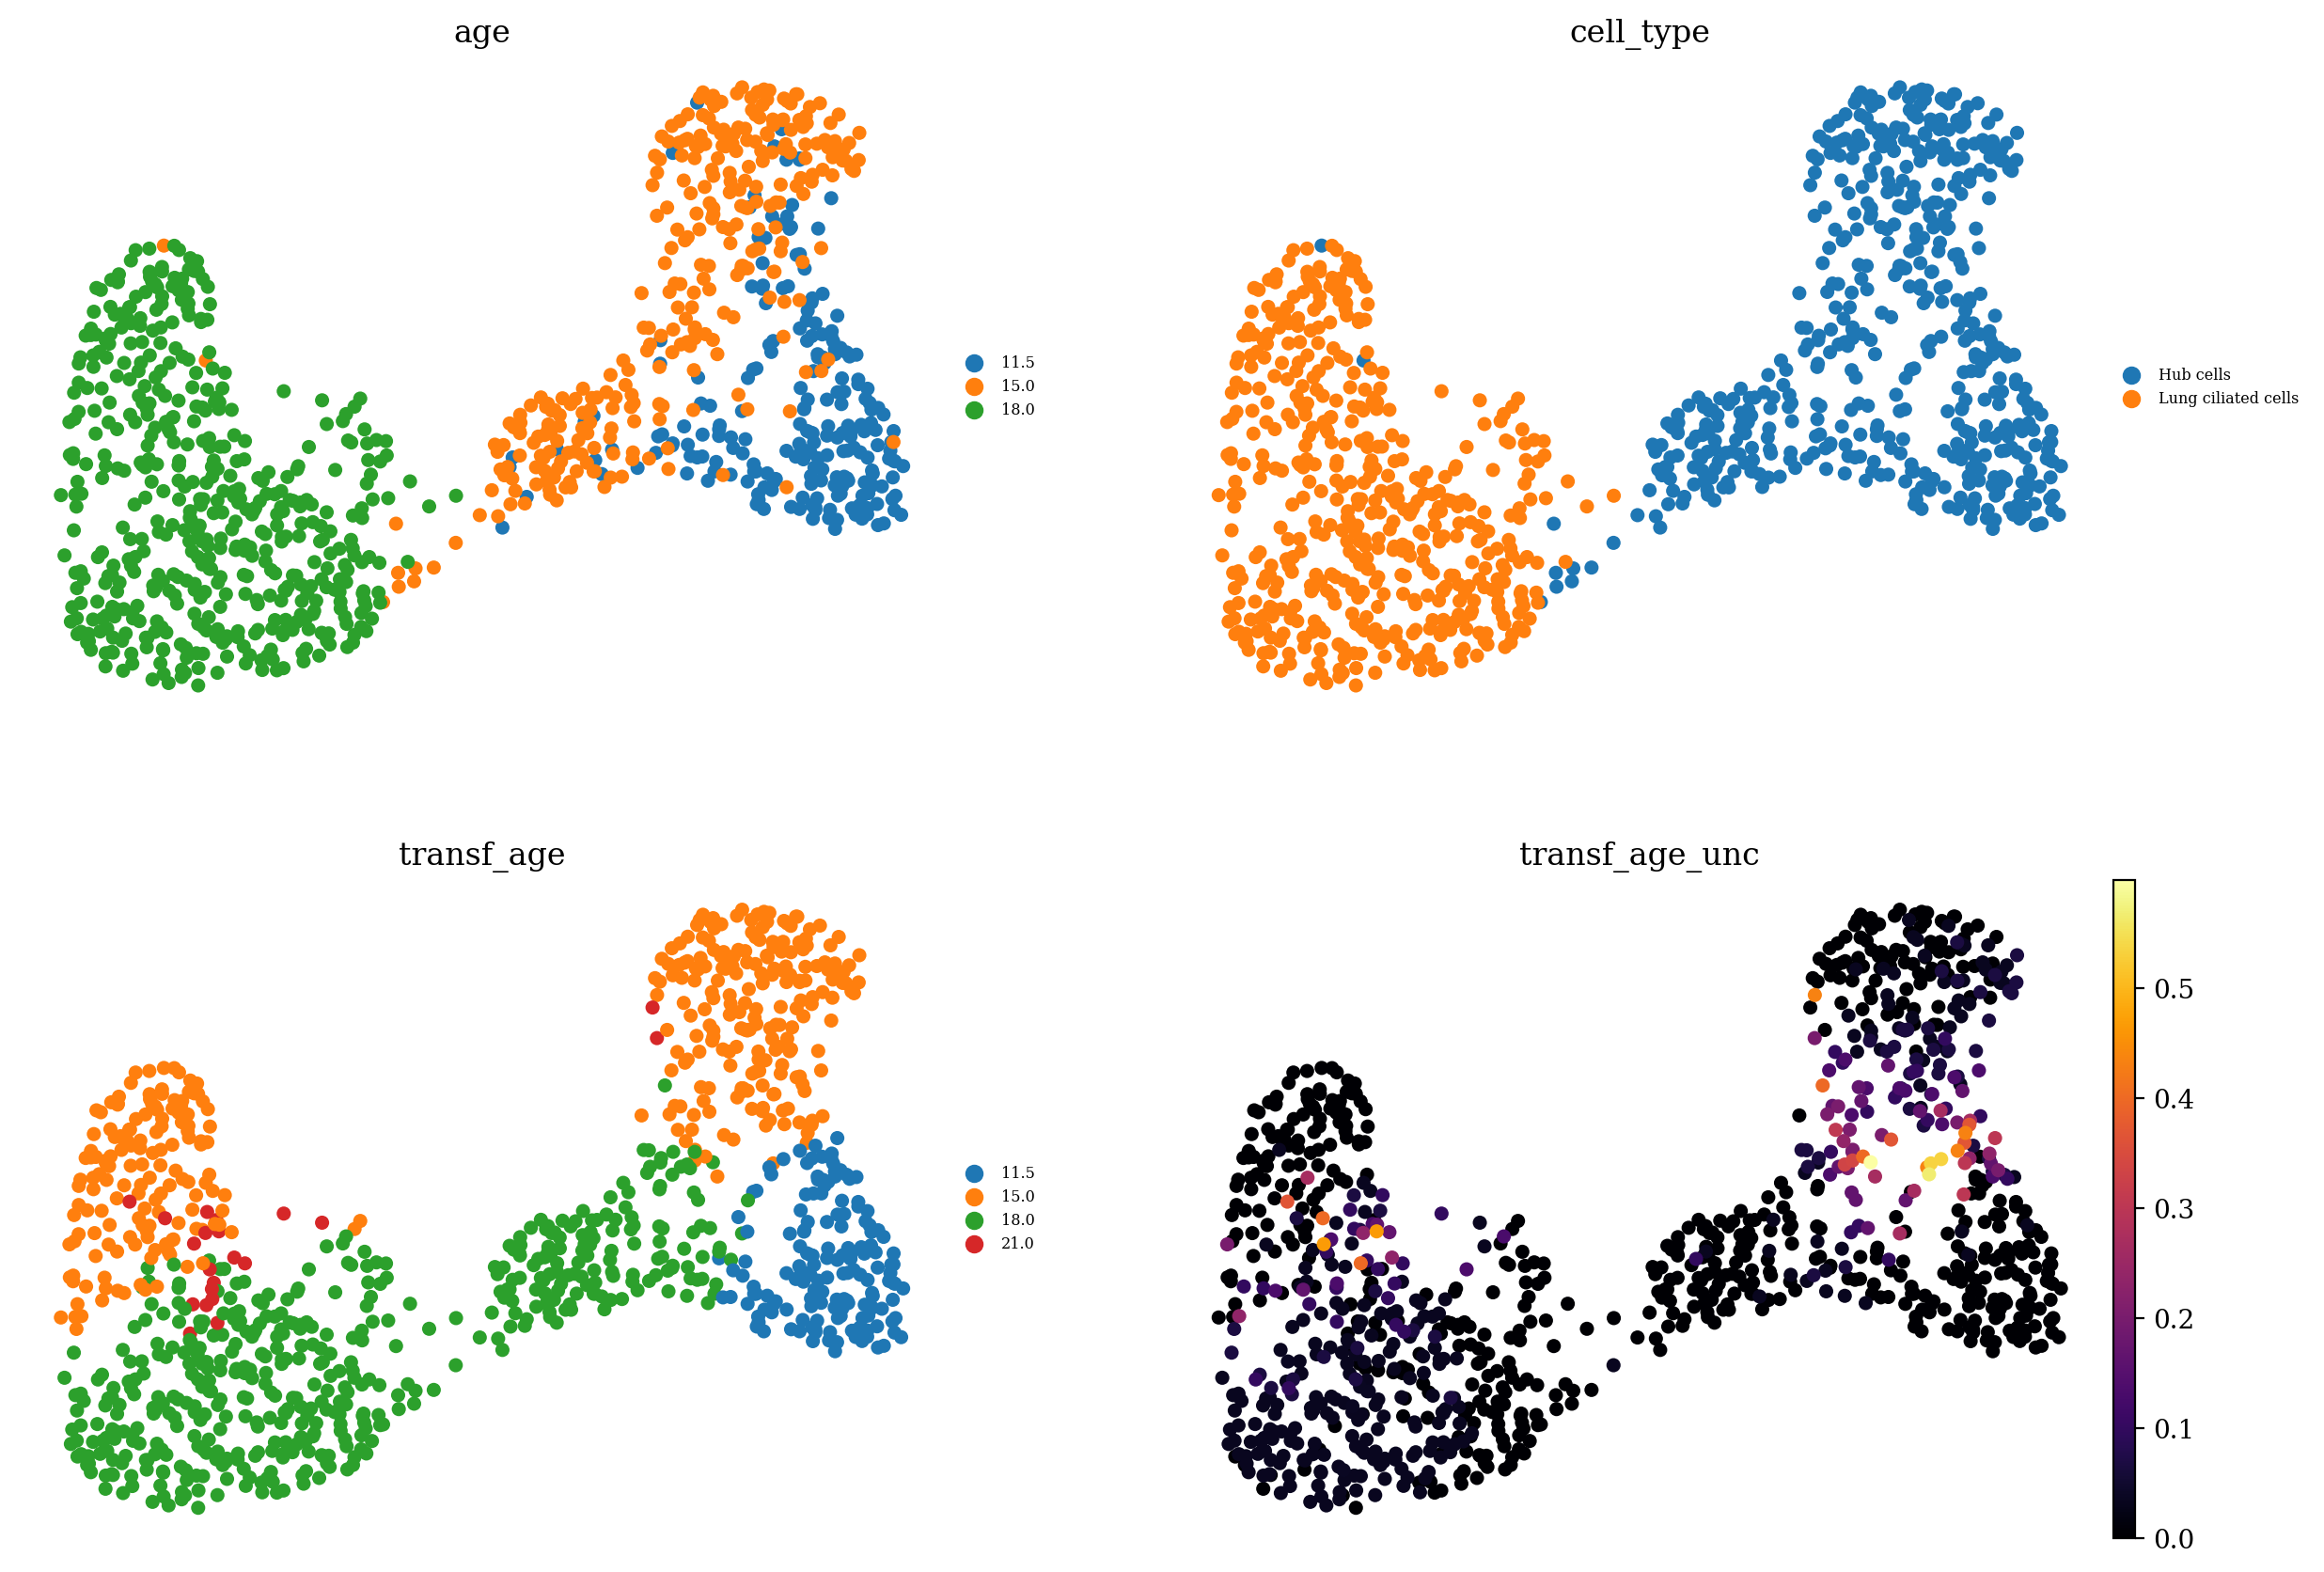

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=["age", "cell_type", "transf_age", "transf_age_unc"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )